In [1]:
import requests
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
# got team names from set(df.team1).union(df.team2)
# Arizona and Cleveland unassigned
team_assignment = {
 'Arizona': '',
 'Atlanta': 'Matt',
 'Baltimore': 'John',
 'Buffalo': 'Ryan',
 'Carolina': 'Ryan',
 'Chicago': 'Aaron',
 'Cincinnati': 'Jon',
 'Cleveland': '',
 'Dallas': 'Brad',
 'Denver': 'Micah',
 'Detroit': 'Colin',
 'Green Bay': 'Jon',
 'Houston': 'Colin',
 'Indianapolis': 'Colin',
 'Jacksonville': 'Brian',
 'Kansas City': 'Ryan',
 'L.A. Chargers': 'Matt',
 'L.A. Rams': 'John',
 'Miami': 'Brad',
 'Minnesota': 'Josh',
 'N.Y. Giants': 'John',
 'N.Y. Jets': 'Josh',
 'New England': 'Aaron',
 'New Orleans': 'Micah',
 'Oakland': 'Matt',
 'Philadelphia': 'Brad',
 'Pittsburgh': 'Brian',
 'San Francisco': 'Aaron',
 'Seattle': 'Jon',
 'Tampa Bay': 'Brian',
 'Tennessee': 'Micah',
 'Washington': 'Josh'}

In [3]:
persons = sorted(list(set(p for p in team_assignment.values() if p!='')))
persons

['Aaron',
 'Brad',
 'Brian',
 'Colin',
 'John',
 'Jon',
 'Josh',
 'Matt',
 'Micah',
 'Ryan']

In [26]:
# get full html of page
r = requests.get("https://projects.fivethirtyeight.com/2018-nfl-predictions/games/")

raw = r.text

# html for each game table
# first element is not relevant
games = raw.split('<table class="game-body">')[1:]
len(games)

256

In [27]:
def team_split(game):
    """split team text"""
    return game.split('<td class="td text team')[1:]

def team_name(team_raw):
    """extract team name"""
    part = team_raw.split('">')[1]
    return part.split('</td>')[0].strip()

def team_probability(team_raw):
    """extract win probability for team
    apparently they put 'loser' and 'winner' in the class name when the game is complete"""
    if 'loser">' in team_raw:
        return 0
    elif 'winner">' in team_raw:
        return 1
    else: 
        part = team_raw.split('%</td><td class="td number score">')[0]
        return float(part.split('>')[-1])/100

In [28]:
# function example usage
game = games[100]
team1, team2 = team_split(game)
print(team_name(team1), team_name(team2))
print(team_probability(team1), team_probability(team2))

Indianapolis Oakland
0.34 0.66


In [80]:
# build game probabilities data frame
data = []
for game in games:
    team1, team2 = team_split(game)
    team1_name, team2_name = team_name(team1), team_name(team2)
    person1, person2 = team_assignment[team1_name], team_assignment[team2_name]
    info = [team1_name, team2_name, team_probability(team1), team_probability(team2), person1, person2]
    data.append(info)
    
cols = ["team1", "team2", "prob1", "prob2", "person1", "person2"]
df = pd.DataFrame(data, columns=cols)
df.to_csv("games.txt", index=False)
df[:5]

,team1,team2,prob1,prob2,person1,person2
0,Baltimore,Cincinnati,0.00,1.00,John,Jon
1,Carolina,Atlanta,0.38,0.62,Ryan,Matt
2,Cleveland,New Orleans,0.15,0.85,,Micah
3,Houston,Tennessee,0.30,0.70,Colin,Micah
4,Indianapolis,Washington,0.25,0.75,Colin,Josh


In [81]:
# test scenarios
"""
df.loc[df.team1=="Detroit", "prob1"] = 1
df.loc[df.team1=="Detroit", "prob2"] = 0
df.loc[df.team2=="Detroit", "prob1"] = 0
df.loc[df.team2=="Detroit", "prob2"] = 1
df[(df.team1=="Detroit") | (df.team2=="Detroit")]
"""

'\ndf.loc[df.team1=="Detroit", "prob1"] = 1\ndf.loc[df.team1=="Detroit", "prob2"] = 0\ndf.loc[df.team2=="Detroit", "prob1"] = 0\ndf.loc[df.team2=="Detroit", "prob2"] = 1\ndf[(df.team1=="Detroit") | (df.team2=="Detroit")]\n'

In [82]:
# current and best possible score by person
current = []
for p in persons:
    certain_win = possible_win = ((df.person1==p) & (df.prob1==1)) | ((df.person2==p) & (df.prob2==1))
    possible_win = ((df.person1==p) & (df.prob1>0)) | ((df.person2==p) & (df.prob2>0))
    current.append([p, certain_win.sum(), possible_win.sum()])
    
df_current = pd.DataFrame(current, columns=['person', 'wins', 'max_possible']).set_index("person")
df_formatted = df_current.sort_values(['wins','max_possible'], ascending=False)
df_formatted.to_csv("scores.txt", sep=" ", header=False)
df_formatted

,wins,max_possible
person,,
Josh,3,47
Jon,3,46
Ryan,2,47
John,2,46
Brad,2,45
Brian,2,45
Micah,1,46
Aaron,1,44
Colin,0,43


In [76]:
# simulate seasons
n_sims = 20000
sims = []
for index, g in df.iterrows():
    a = [g['person1'], g['person2']]
    p = [g['prob1'], g['prob2']]
    if sum(p) != 0:
        game_sims = np.random.choice(a, n_sims, p=p)
    sims.append(game_sims)

sims = np.array(sims).T
sims.shape

(20000, 256)

In [77]:
# aggregate seasons into scores for each person
df_wins = pd.DataFrame([Counter(s) for s in sims])[persons]
print(df_wins.shape)
df_wins[:5]

(20000, 10)


,Aaron,Brad,Brian,Colin,John,Jon,Josh,Matt,Micah,Ryan
0,27,33,25,24,24,25,22,22,24,21
1,18,30,33,30,21,24,22,22,25,23
2,20,26,31,26,22,19,31,25,19,30
3,21,23,27,28,27,22,29,24,25,20
4,23,25,25,27,17,29,26,21,23,29


In [78]:
# use min method because ties take from following placements
# mistakenly used dense at first
df_rank = df_wins.rank(axis=1, method="min", ascending=False).astype(int)
df_rank[:5]

,Aaron,Brad,Brian,Colin,John,Jon,Josh,Matt,Micah,Ryan
0,2,1,3,5,5,3,8,8,5,10
1,10,2,1,2,9,5,7,7,4,6
2,8,4,1,4,7,9,1,6,9,3
3,9,7,3,2,3,8,1,6,5,10
4,7,5,5,3,10,1,4,9,7,1


In [79]:
rank1 = (df_rank==1).sum(0) / n_sims
rank2 = (df_rank<=2).sum(0) / n_sims
rank3 = (df_rank<=3).sum(0) / n_sims

probs = pd.concat([rank1, rank2, rank3], axis=1)
probs.columns = ["1", "2", "3"]
probs.sort_values("1", ascending=False).style.format("{:.1%}")

,1,2,3
Brian,33.1%,52.1%,66.2%
Colin,25.3%,49.0%,66.7%
Brad,19.1%,36.0%,50.6%
Ryan,17.4%,32.9%,46.8%
Josh,11.7%,24.4%,37.1%
Jon,4.4%,11.1%,19.7%
Matt,4.1%,10.2%,18.0%
Micah,3.7%,8.9%,15.0%
John,2.9%,7.6%,13.6%
Aaron,1.7%,5.4%,10.6%


In [35]:
formatted = (probs*100).sort_values("1", ascending=False).round(1).astype(float).astype(str)+'%'
formatted.to_csv("probabilities.txt", sep=" ", header=False)

In [52]:
import seaborn as sns
%matplotlib inline

In [62]:
person_sort = probs.sort_values("1", ascending=False).index

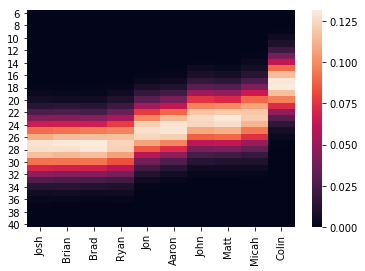

In [63]:
# score distribution for individual players
dist_df = []
for person in persons:
    dist_df.append(pd.DataFrame(df_wins.groupby(person).size() / n_sims))

dist_df = pd.concat(dist_df, axis=1).fillna(0)
dist_df.columns = persons
#dist_df.style.format("{:.1%}")
sns.heatmap(dist_df[person_sort], annot=False)